# Image generation

In Part 1 of this course, we focused mainly on models that were useful for classification. However, many applications require generating much higher dimensional results, such as images and sentences. Examples include:
* Text: neural translation, text to speech, image captioning
* Image: Segmentation, artistic filters, image sharpening and cleaning

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Tell Tensorflow to use no more GPU RAM than necessary
limit_mem()

Data can be downloaded from [here](http://files.fast.ai/data/imagenet-sample-train.tar.gz). Update path below to where you download data to. Optionally use a 2nd path for fast (e.g. SSD) storage - set both to the same path if using AWS.

In [3]:
path = '../../../Data/imagenet-sample-train/'
dpath = '../../../Data/'
#path = '../data2/train/'
#dpath = '../data2/'

## Neural style transfer

The first use case of an image to image architecture we're going to look at is neural style transfer, using the approach in [this paper](https://arxiv.org/abs/1508.06576). This is a fairly popular application of deep learning in which an image is recreated in the style of a work of art, such as Van Gogh's Starry Night. For more information about the use of neural networks in art, see this [Scientific American article](https://blogs.scientificamerican.com/sa-visual/neural-networks-for-artists/) or [Google's Magenta Project](https://magenta.tensorflow.org/welcome-to-magenta).

### Setup

Our first step is to list out the files we have, and then grab some image.

In [4]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(fnames)
n

19439

In [5]:
fn = fnames[90]
fn

'../../../Data/imagenet-sample-train\\train\\n01494475\\n01494475_281.JPEG'

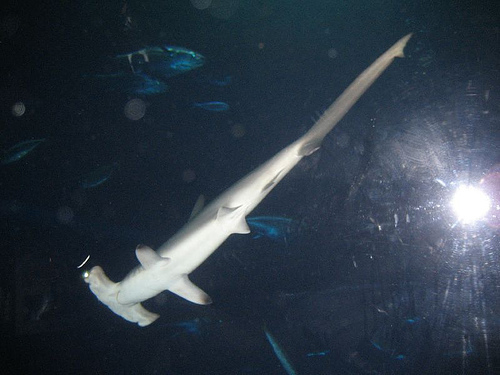

In [6]:
img=Image.open(fnames[90]); img

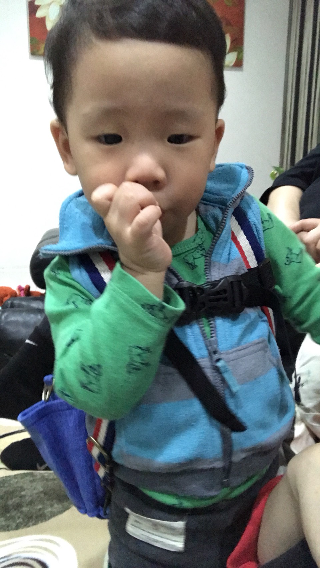

In [50]:
img=Image.open('data/neural-style/adam1.jpg'); 
img = img.resize(np.divide(img.size, 3).astype('int32'))
img

That's a nice looking image! Feel free to use any other image that you're interested in playing with.

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using *broadcasting*, which is a topic we'll be returning to many times during this course.

In [51]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:,: ,:, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [52]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [53]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

### Recreate input

The first step in style transfer is understanding how to recreate an image from noise based on **"content loss"**, which is the amount of difference between activations in some layers. In earlier layers, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.

To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (i.e. random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs. 

The interesting part is that now, instead of updating the parameters of the CNN, we update the pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.

In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both theano and tensorflow with the same code.

The CNN we'll use is VGG16, but with a twist. Previously we've always used Vgg with max pooling, and this was useful for image classification. It's not as useful in this case however, because max pooling loses information about the original input area. Instead we will use average pooling, as this does not throw away as much information.

In [54]:
model = VGG16_Avg(include_top=False)

Here we're grabbing the activations from near the end of the convolutional model).

In [55]:
layer = model.get_layer('block5_conv1').output

And let's calculate the target activations for this layer:

In [56]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In our implementation, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scikit-learn's optimizers require.

In [57]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

**[trouble shooting for Keras 2.0](http://forums.fast.ai/t/python-3-upgrade-troubleshooting-aug-2017-edition/4556/2)**

In [58]:
#loss = metrics.mse(layer, targ)
loss = K.mean(metrics.mse(layer, targ))

grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search, which we can implement with sklearn's `fmin_l_bfgs_b` function. 

In [59]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x0=x.flatten(), 
                                        fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print('Current loss value:', np.mean(min_val))
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
        #print(info)
    return x

Next we need to generate a random image.

(568, 320, 3)


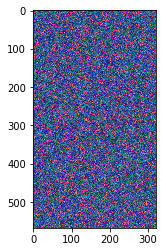

In [60]:
rand_img = lambda shape: np.random.uniform(-25, 25, shape)/100
#rand_img = lambda shape: np.random.uniform(25, 75, shape)/100
x = rand_img(shp)
print(x[0].shape)
plt.imshow(deproc(x.copy(), shp)[0]);

Now we'll run through this optimization approach ten times and train the noise image's pixels as desired.

In [61]:
iterations = 10

In [ ]:
x.shape

(1, 568, 320, 3)

In [ ]:
x = solve_image(evaluator, iterations, x)

Current loss value: 76.9578018188
Current loss value: 33.0681343079


Our result by comparing output at conv 1 of last block (5) is fairly amorphous, but still easily recognizable as a bird. Notice that the things it has reconstructed particularly well are those things that we expect Vgg16 to be good at recognizing, such as an eye or a beak.

In [ ]:
Image.open(path + '/results/res_at_iteration_9.png')

If instead we optimized by calculating loss from the output of conv 1 of 4th block, our trained image looks much more like the original. This makes sense because with less transformations to go through, comparing at an earlier layer means that we have a smaller receptive field and the features are more based on geometric details rather than broad features.

In [ ]:
Image.open(path + '/results/res_at_iteration_9.png')

In [ ]:
from IPython.display import HTML
from matplotlib import animation, rc

In [ ]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{path}/results/res_at_iteration_{i}.png'))

The optimizer first focuses on the important details of the bird, before trying to match the background.

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

### Recreate style

Now that we've learned how to recreate an input image, we'll move onto attempting to recreate *style*. By "style", we mean the color palette and texture of an image. Unlike recreating based on content, with style we are not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of "style".

Here are some examples of images we can extract style from.

In [ ]:
def plot_arr(arr): 
    plt.imshow(deproc(arr, arr.shape)[0].atype('uint8'))

In [ ]:
style = Image.open('data/neural-style/abstract.jpg')
style = style.resize(np.divide(style.size, 1.5).astype('int32'))
style

In [ ]:
style = Image.open('data/neural-style/interest.jpg')
style = style.resize(np.divide(style.size, 1.5).astype('int32'))
style

In [ ]:
style = Image.open('data/neural-style/simpsons.jpeg')
style = style.resize(np.divide(style.size, 3).astype('int32'))
style

We're going to repeat the same approach as before, but with some differences.

In [ ]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape
shp

In [ ]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

One thing to notice is that we're actually going to be calculating the loss function multiple layers, rather than just one. (Note however that there's no reason you couldn't try using multiple layers in your content loss function, if you wanted to try that).

In [ ]:
layers = [outputs[f'block{o}_conv1'] for o in range(1,3)]

In [ ]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

The key difference is our choice of loss function. Whereas before we were calculating mse of the raw convolutional outputs, here we transform them into the **"gramian matrix"** of their channels (that is, the product of a matrix and its transpose) before taking their mse. It's unclear why this helps us achieve our goal, but it works. One thought is that the gramian  shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [ ]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements() 

In [ ]:
def style_loss(x, targ):
    return K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [ ]:
loss = sum(style_loss(l1[0], l2[0]) for l1, l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

We then solve as we did before.

In [ ]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
#rand_img = lambda shape: np.random.uniform(25, 75, shape)/100
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])
print(x[0].shape)
#plt.imshow(x[0])
plt.imshow(deproc(x.copy(), shp)[0]);

In [ ]:
iterations = 10
x = rand_img(shp)

In [ ]:
x = solve_image(evaluator, iterations, x)

Our results are stunning. By transforming the convolutional outputs to the gramian, we are somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure or meaning.

In [ ]:
Image.open(path + '/results/res_at_iteration_9.png')

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

### Style transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

In [ ]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [ ]:
style_layers = [outputs[f'block{o}_conv2'] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [ ]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [ ]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous two functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [ ]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [ ]:
loss = sum( style_loss(l1[0], l2[0]) * w 
            for l1, l2, w in zip(style_layers, style_targs, style_wgts) )
loss += K.mean(metrics.mse(content_layer, content_targ))/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(transfer_fn, shp)

In [ ]:
iterations=10
x = rand_img(shp)

In [ ]:
x = solve_image(evaluator, iterations, x)

These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

In [ ]:
Image.open(path + '/results/res_at_iteration_9.png')

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

There are lots of interesting additional things you could try, such as the ideas shown here: https://github.com/titu1994/Neural-Style-Transfer .

## Use content loss to create a super-resolution network

So far we've demonstrated how to achieve succesful results in style transfer. However, there is an obvious drawback to our implementation, namely that we're training an image, not a network, and therefore every new image requires us to retrain. It's not a feasible method for any sort of real-time application. Fortunately we can adress this issue by using a fully convolutional network (FCN), and in particular we'll look at this implementation for Super resolution. We are following the approach in [this paper](https://arxiv.org/abs/1603.08155).